# Predicting the Stock Market
The S&P 500 stock market index is the aggregate performance of the largest 500 companies in the United States.  The S&P 500 is an ETF, Exchange Traded Fund, that anyone can buy or sell. Historical data of daily activity for the S&P 500 goes back to the year 1950. The closing price is the value of the index at the end of a day of trading. In this Dataquest project, linear regression models will incorporate various indicators from historical data from 1950-2012 to predict the closing prices from 2013-2015. The best the model is the one that returns the lowest RMSE (root-mean-squared-error) without over-fitting.

### Project Purpose
This project is for the completion of the DataQuest.io https://www.dataquest.io/ "Machine Learning in Python:Intermediate" module; the twenty-fourth in a series for completing the Data Science course path. 

### Summary of the Results
The best predictor of the close price of the S&P 500 returns an RMSE value of 22.167.  It's a linear regression model using the following five indicators collectively: *five day rolling average, one year rolling average, year component, five day rolling standard deviation, one year rolling standard deviation*. 

# Data Source and Exploration
For teaching purposes, Dataquest provided a file in .csv format containing a daily trading records of the S&P500 index from 1950 to 2015. It contains 16589 rows and seven columns, which are as follows:

|Column Name|Explanation|
| :-------: | :--- |
|Date|The date of the record.|
|Open|The opening price of the day (when trading starts).|
|High|The highest trade price during the day.|
|Low|The lowest trade price during the day.|
|Close|The closing price for the day (when trading is finished).|
|Volume|The number of shares traded.|
|Adj Close|The daily closing price, adjusted retroactively to include any corporate actions.|


In [702]:
# Begin by reading in the data an importing the appropriated python libraries

import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns

# Convert the values in the Date column into a datetime objects, so dates can be parsed as needed
d_parser = lambda x : dt.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('sphist.csv', parse_dates=['Date'], date_parser = d_parser)

# Sort the values in ascending order by date
df.sort_values(by = 'Date', inplace = True)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


# Selecting the Indicators 
Selecting the appropriate combination of indicators to train a model on is key to producing accurate predictions. Selecting too few will result in under-fitting; selecting too many will result in over-fitting. This project explores various combinations of the following indicators: 

- The average price from the past 5 days.
- The standard deviation of the price over the past 5 days.
- The average price for the past year.
- The standard deviation of the price over the past year.
- The ratio between the average price for the past 5 days, and the average price for the past year.
- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past year.
- The average volume from the past 5 days 
- The average volume for the past year.
- The year component of the date
- The month component of the date
- The day component of the date


Note: The NYSE and NASDAQ average about 253 trading days a year since they are closed on weekends and holidays.

### Calculating Rolling Aggregates
Stock market data is sequential and each observation comes a day after the previous observation. Care must be taken to insure that "future" knowledge is not inadvertently injected into "past" rows when training and making predictions. Therefore, the "current" row is not included in the values being averaged to train the model to predict the "current" price from the historical prices. This applies to the standard deviation and volume calculations as well. To use the first five day rolling average as an example: The closing prices from 1950-01-03 to 1950-01-09 were averaged together; the value of which was 16.90 dollars. A new column named "five_day_$_ave" was created to hold that value on 1950-01-10. The calculations continue to 'roll' forward this way for each date in the row. The same goes for standard deviation and volume. The example for the five day rolling average, is applied similarly year rolling averages; except, the first entries for the respective columns don't start until 1951-01-04. This is because it requires the entire first year to collect and aggregate the values. 

The pandas library has a time series tool called "rolling" which makes rolling calculations easy; however, the .shift method must be applied to insure the data is shifted "forward" one day (or one year) to insure that predictions are not made on the "current" rows. (Making predictions on current already 'known' data wouldn't be much of a prediction, and would cause over-fitting). 

In [703]:
# Create a copy of the dataframe for 5 day model
df_5day = df.copy()

In [704]:
# Create two new columns to hold five day ave and std dev.
df_5day['five_day_$_ave'] = 0
df_5day['five_day_$_std'] = 0
df_5day['five_day_vol_ave'] = 0

In [705]:
# Use the rolling function from pandas to calculate mean and standard over 5 days, 
# and reindex the results to shift forward one day. 
df_5day['five_day_$_ave'] = df_5day['Close'].rolling(5).mean().shift(periods = 1).round(2)
df_5day['five_day_$_std'] = df_5day['Close'].rolling(5).std().shift(periods = 1).round(2)
df_5day['five_day_vol_ave'] = df_5day['Volume'].rolling(5).mean().shift(periods = 1).round(2)

In [706]:
#The resulting dataframe begins calculating the rolling average 
# and standard deviation from the close from the previous 5 days
df_5day.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,five_day_$_ave,five_day_$_std,five_day_vol_ave
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.90,0.16,2046000.0
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.97,0.09,2226000.0
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.02,0.07,2374000.0
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.99,0.13,2458000.0
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.93,0.20,2722000.0


In [707]:
# Create a copy of the dataframe for 1 year model
df_1year = df.copy()
# Create two new columns to hold 1 year ave and std dev.
df_1year['one_year_$_ave'] = 0
df_1year['one_year_$_std'] = 0
df_1year['one_year_vol_ave'] = 0
# Use the rolling function from pandas to calculate mean and standard over 1 year, 
# and reindex the results to shift forward one year. 
df_1year['one_year_$_ave'] = df_1year['Close'].rolling(251).mean().shift(periods = 1)
df_1year['one_year_$_std'] = df_1year['Close'].rolling(251).std().shift(periods = 1)
df_1year['one_year_vol_ave'] = df_1year['Volume'].rolling(251).mean().shift(periods = 1)

In [708]:
#The resulting dataframe begins calculating the rolling average 
# and standard deviation from the close from the previous year starting on 1951-01-03
df_1year.loc[16339:16330]

,Date,Open,High,Low,Close,Volume,Adj Close,one_year_$_ave,one_year_$_std,one_year_vol_ave
16339,1951-01-03,20.690001,20.690001,20.690001,20.690001,3370000.0,20.690001,NaN,NaN,NaN
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,18.415857,1.075940,2.018725e+06
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,18.432630,1.081260,2.027211e+06
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,18.448646,1.087479,2.033187e+06
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,18.464861,1.095061,2.034104e+06
16334,1951-01-10,20.850000,20.850000,20.850000,20.850000,3270000.0,20.850000,18.481355,1.103751,2.041235e+06
16333,1951-01-11,21.190001,21.190001,21.190001,21.190001,3490000.0,21.190001,18.496375,1.110237,2.044223e+06
16332,1951-01-12,21.110001,21.110001,21.110001,21.110001,2950000.0,21.110001,18.512948,1.119273,2.049522e+06
16331,1951-01-15,21.299999,21.299999,21.299999,21.299999,2830000.0,21.299999,18.528964,1.127561,2.050797e+06
16330,1951-01-16,21.459999,21.459999,21.459999,21.459999,3740000.0,21.459999,18.547052,1.135457,2.050239e+06


In [709]:
# Combine the data sets by adding the one year ave column and the one year standard deviation column to the 5 day dataframe
df_5day['one_year_$_ave'] = df_1year['one_year_$_ave']
df_5day['one_year_$_std'] = df_1year['one_year_$_std']
df_5day['one_year_vol_ave'] = df_1year['one_year_vol_ave']

In [710]:
# Rename the consolidated dataframe "Combined"
combined = df_5day.copy()

In [711]:
combined.set_index('Date')

,Open,High,Low,Close,Volume,Adj Close,five_day_$_ave,five_day_$_std,five_day_vol_ave,one_year_$_ave,one_year_$_std,one_year_vol_ave
Date,,,,,,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.02,3.92,3.207544e+09,2061.114504,55.365217,3.631371e+09
2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.23,7.96,3.232372e+09,2061.258248,55.426189,3.631473e+09
2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.31,9.33,3.245514e+09,2061.278885,55.432040,3.632819e+09


### Rolling Ratio Between 5 Day Average / 1 Year Average. 
The rolling ratio between the 5 day average and 1 year average is calculated and added to a new column in the combined data frame. 

In [712]:
combined['ratio_mean_price_5day_to_year'] = combined['five_day_$_ave']/combined['one_year_$_ave']

### Rolling Ratio Between 5 Day Standard Deviation / 1 Year Standard Deviation
This rolling ration between the 5 day standard deviation and the 1 year standard deviation is calculated and added to a new column in the combined data frame. 

In [713]:
combined['ratio_mean_price_std_5day_to_year'] = combined['five_day_$_std']/combined['one_year_$_std']

### Extracting Years, Months, Days from Datetime Objects
Dates are provided in the format "YYYY-MM-DD". The year, month and date components by themselves could be good indicators for making predictions on the close price. they are extracted into their own columns for easier modeling.

In [714]:
combined['year_only'] = combined['Date'].dt.year
combined['month_only'] = combined['Date'].dt.month
combined['day_only']= combined['Date'].dt.day

In [715]:
# The final list of columns is as follows:
combined.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'five_day_$_ave', 'five_day_$_std', 'five_day_vol_ave',
       'one_year_$_ave', 'one_year_$_std', 'one_year_vol_ave',
       'ratio_mean_price_5day_to_year', 'ratio_mean_price_std_5day_to_year',
       'year_only', 'month_only', 'day_only'],
      dtype='object')

In [716]:
combined

,Date,Open,High,Low,Close,Volume,Adj Close,five_day_$_ave,five_day_$_std,five_day_vol_ave,one_year_$_ave,one_year_$_std,one_year_vol_ave,ratio_mean_price_5day_to_year,ratio_mean_price_std_5day_to_year,year_only,month_only,day_only
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,3
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,4
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,5
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,6
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.02,3.92,3.207544e+09,2061.114504,55.365217,3.631371e+09,1.012569,0.070803,2015,12,1
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.23,7.96,3.232372e+09,2061.258248,55.426189,3.631473e+09,1.014055,0.143614,2015,12,2
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.31,9.33,3.245514e+09,2061.278885,55.432040,3.632819e+09,1.013114,0.168314,2015,12,3
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.46,19.60,3.536224e+09,2061.190042,55.432787,3.636397e+09,1.009349,0.353581,2015,12,4


# Initial Data Cleaning
Since there isn't enough historical data from the new indicator columns that were created to compute rows that fall before 1951-01-03, those columns are removed. 

In [717]:
# Copy the dataframe and drop dates prior to 1951-01-03
combined = combined.copy()
combined = combined[combined['Date'] > dt.datetime(year=1951, month=1, day=2)]

In [718]:
# Drop any rows with NA values
combined.dropna(axis = 0, how = 'any', inplace=True)
combined.shape
print('The final dataframe contains {} rows and {} columns\n'.format(combined.shape[0],combined.shape[1]))
print('The final {} columns are:\n\n {}'.format(combined.shape[1],combined.columns.values))

The final dataframe contains 16339 rows and 18 columns

The final 18 columns are:

 ['Date' 'Open' 'High' 'Low' 'Close' 'Volume' 'Adj Close' 'five_day_$_ave'
 'five_day_$_std' 'five_day_vol_ave' 'one_year_$_ave' 'one_year_$_std'
 'one_year_vol_ave' 'ratio_mean_price_5day_to_year'
 'ratio_mean_price_std_5day_to_year' 'year_only' 'month_only' 'day_only']


# Splitting the Data Set for Training and Testing
The cleaned, combined data frame contains 16339 rows. Next, this data is split into two new data frames to create the algorithms. Rows with dates prior to 2013/1/1 are split into the "training" data frame; the remaining rows are reserved for the "testing" data frame. The linear regression model is selected to make predictions, and mean squared error is selected as the metric.

In [719]:
train = combined[combined['Date'] < dt.datetime(year=2013, month=1, day=1)]
test = combined[combined['Date'] >= dt.datetime(year=2013, month=1, day=1)]
train.shape

(15600, 18)

In [720]:
test.shape

(739, 18)

# Determining which Indicators to Keep or Discard
There are a lot of indicators; some of which may cause over-fitting, while others may cause under-fitting. Determining which ones to keep or discard can be very tedious and time consuming. Therefore, visual tools are used to better understand the  relationships to the close price. These include correlation heat-maps and linear plots. 

### Observing Correlation Coefficients
Since the close price is the target, pandas correlation method is used to find out which indicators correlated the closest.  Adj Close, Low, High and Open correlate so closely to the close Price that they're redundant and will likely cause the data to over-fit. On the opposite end of the spectrum; the ratio indicators, and the month and day components have very little correlation and are dropped. A heat-map showing a graphical representation of the remaining indicators is shown below. 

In [721]:
train_subset = train.corr()
train_close = train_subset['Close']
sorted_corr = train_close.abs().sort_values(ascending = False)
sorted_corr

Adj Close                            1.000000
Close                                1.000000
Low                                  0.999946
High                                 0.999945
Open                                 0.999879
five_day_$_ave                       0.999758
one_year_$_ave                       0.991110
year_only                            0.864737
one_year_$_std                       0.784537
five_day_$_std                       0.742646
one_year_vol_ave                     0.738936
five_day_vol_ave                     0.738792
Volume                               0.731393
ratio_mean_price_std_5day_to_year    0.135674
month_only                           0.012569
ratio_mean_price_5day_to_year        0.006806
day_only                             0.000087
Name: Close, dtype: float64

In [722]:
filt = (sorted_corr > 0.738) & (sorted_corr < .99980)
sorted_corr = sorted_corr[filt]
strong_corr = sorted_corr.index
strong_corr

Index(['five_day_$_ave', 'one_year_$_ave', 'year_only', 'one_year_$_std',
       'five_day_$_std', 'one_year_vol_ave', 'five_day_vol_ave'],
      dtype='object')

<AxesSubplot:>

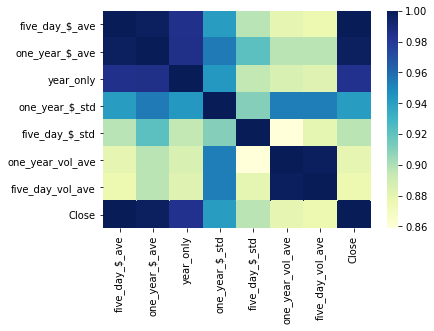

In [723]:
corr_map = train_subset[['five_day_$_ave', 'one_year_$_ave', 'year_only', 'one_year_$_std',
       'five_day_$_std', 'one_year_vol_ave', 'five_day_vol_ave', 'Close']]
corr_map.corr()
sns.heatmap(corr_map.corr(), cmap="YlGnBu")

### Observing Yearly Linear Relationships
Line plots can be useful for observing trends over time. The linear plot of the Close, the 5 day and the one year rolling average shows how closely they trend together over time. 

The other indicators all use a different metric, so they are rescaled from 0 to 1 in order to be comparable.
They do not trend as close, especially toward the later years. They actually appear to be trending ahead or behind the close price in the years after 2000. Without later data, it's unknown how these trends will play out, and will most likely impact the ability to make accurate predictions. 

In [724]:
# Set the 'year_only' column to the index and rename it 'year'. Create a new dataframe.
index_year = combined.set_index('year_only')
index_year = index_year.rename_axis('year')
index_year = index_year[['five_day_$_ave', 'one_year_$_ave', 'one_year_$_std',
       'five_day_$_std', 'one_year_vol_ave', 'five_day_vol_ave', 'Close']]
index_year

,five_day_$_ave,one_year_$_ave,one_year_$_std,five_day_$_std,one_year_vol_ave,five_day_vol_ave,Close
year,,,,,,,
1951,20.51,18.415857,1.075940,0.20,2.018725e+06,3.268000e+06,20.870001
1951,20.63,18.432630,1.081260,0.21,2.027211e+06,3.358000e+06,20.870001
1951,20.73,18.448646,1.087479,0.18,2.033187e+06,3.324000e+06,21.000000
1951,20.84,18.464861,1.095061,0.12,2.034104e+06,3.192000e+06,21.120001
1951,20.91,18.481355,1.103751,0.16,2.041235e+06,3.346000e+06,20.850000
...,...,...,...,...,...,...,...
2015,2087.02,2061.114504,55.365217,3.92,3.631371e+09,3.207544e+09,2102.629883
2015,2090.23,2061.258248,55.426189,7.96,3.631473e+09,3.232372e+09,2079.510010
2015,2088.31,2061.278885,55.432040,9.33,3.632819e+09,3.245514e+09,2049.620117


<AxesSubplot:xlabel='year'>

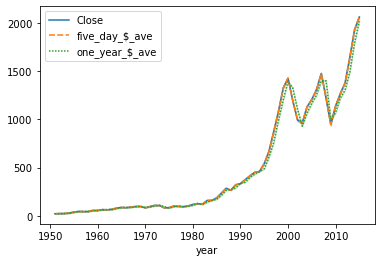

In [725]:
#Observe how the five day rolling average and the one year rolling average trend with the Close price.
sns.lineplot(data=index_year[["Close", "five_day_$_ave", "one_year_$_ave"]])

In [726]:
# rescale the other indicators
rescale_cols= ['Close','one_year_$_std',
       'five_day_$_std', 'one_year_vol_ave', 'five_day_vol_ave']
rescale = (index_year[rescale_cols] - 
              index_year[rescale_cols].min())/(index_year[rescale_cols].max() - 
              index_year[rescale_cols].min())
rescale

,Close,one_year_$_std,five_day_$_std,one_year_vol_ave,five_day_vol_ave
year,,,,,
1951,0.000009,0.001752,0.001991,0.000129,0.000261
1951,0.000009,0.001775,0.002101,0.000131,0.000271
1951,0.000071,0.001801,0.001770,0.000132,0.000267
1951,0.000128,0.001833,0.001106,0.000132,0.000253
1951,0.000000,0.001869,0.001548,0.000133,0.000270
...,...,...,...,...,...
2015,0.986640,0.230010,0.043132,0.595547,0.343796
2015,0.975682,0.230267,0.087812,0.595564,0.346457
2015,0.961516,0.230291,0.102964,0.595785,0.347866


<AxesSubplot:xlabel='year'>

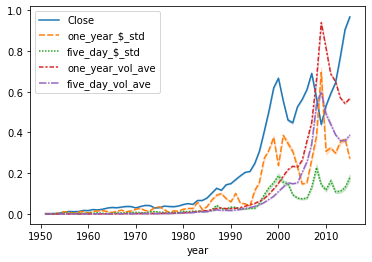

In [727]:
# Observe how the other indicators scale with the close price
sns.lineplot(data=rescale)

# Training and Testing the Model with Linear Regression

In [728]:
# Import the Linear Regression model and select mean squared error as the error metric
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Getting a Baseline with Two Indicators: 5 Day Rolling Average and One Year Rolling Average
A baseline RMSE value of 22.198 is obtained by fitting only two indicators to the Close column: the five day rolling average and one year rolling average columns. Based on the previous visual aids above, these two indicators trend very tightly with the close price and are expected to perform well. 

In [729]:
# 5 Day Rolling Average and One Year Rolling Average
cols = ['five_day_$_ave', 'one_year_$_ave']
lr = LinearRegression()
lr.fit(train[cols], train['Close'])

predictions = lr.predict(test[cols])
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
print('The RMSE value for two indicators is {}'.format(rmse.round(3)))

The RMSE value for two indicators is 22.198


### Improving the Model with the Additional Indicators
The two indicators above perform better alone than any of the other indicators. But, will the addition of more indicators improve the RMSE value further? The following cells show the impact of the RMSE value by adding additional indicators. 

### Adding Year Component
The year component does not improve the RMSE value.

In [730]:
# Adding year component
cols = ['five_day_$_ave', 'one_year_$_ave', 'year_only']
lr = LinearRegression()
lr.fit(train[cols], train['Close'])

predictions = lr.predict(test[cols])
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
print('The RMSE value for three indicators is {}'.format(rmse.round(3)))

The RMSE value for three indicators is 22.215


### Adding 5 Day Rolling Standard Deviation and One Year Rolling Standard Deviation
Adding both the five day and one year rolling standard deviation indicators marginally improve the RMSE value.  

In [731]:
# Adding Rolling standard deviations 
cols = ['five_day_$_ave', 'one_year_$_ave', 'year_only', 'one_year_$_std', 'five_day_$_std']
lr = LinearRegression()
lr.fit(train[cols], train['Close'])

predictions = lr.predict(test[cols])
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
print('The RMSE value for five indicators is {}'.format(rmse.round(3)))

The RMSE value for five indicators is 22.167


### Adding Rolling Volumes
Adding the five day rolling average and the one year rolling average makes the RMSE value worse. 

In [732]:
# Adding Rolling Averages
cols = ['five_day_$_ave', 'one_year_$_ave', 'year_only', 'one_year_$_std', 'five_day_$_std','one_year_vol_ave', 'five_day_vol_ave']
lr = LinearRegression()
lr.fit(train[cols], train['Close'])

predictions = lr.predict(test[cols])
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
print('The RMSE value for seven indicators is {}'.format(rmse.round(3)))

The RMSE value for seven indicators is 22.218


# Conclusion

To predict the close price for the S&P 500, the linear regression model is the obvious choice given the dataset, since the indicators tract quite linearly. The five day rolling average, one year rolling average indicators tread very closely to the close price as shown with heat-map correlations and linear plots. These two indicators are by far the best predictors. Adding three additional indicators only marginally improves the RMSE value to 22.167. As a matter of fact, as time progresses, the other indicators diverge further from the closing price. RMSE values may improve with more data and outside information relating to the cause of these divergences. 